In [2]:
!pip install tensorflow==2.10.0
!pip install numpy==1.23

In [3]:
import tensorflow as tf
print(tf.__version__)  # Should output: 2.10.0

2.10.0


2.10.0
Mounted at /content/drive
Found 1172 images belonging to 3 classes.
Found 292 images belonging to 3 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/25
37/37 [==============================] - 502s 13s/step - loss: 18.6716 - accuracy: 0.5196 - val_loss: 15.6393 - val_accuracy: 0.4144 - lr: 0.0010
Epoch 2/25
37/37 [==============================] - 423s 11s/step - loss: 13.2025 - accuracy: 0.5981 - val_loss: 11.5198 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 3/25
37/37 [==============================] - 433s 12s/step - loss: 9.7579 - accuracy: 0.6271 - val_loss: 8.5011 - val_accuracy: 0.6199 - lr: 0.0010
Epoch 4/25
37/37 [==============================] - 428s 12s/step - loss: 7.5225 - accuracy: 0.6587 - val_loss: 6.7144 - val_accuracy: 0.6473 - lr: 0.0010
Epoch 5/25
37/37 [==============================] - 430s 12s/step - loss: 5.9769 - accuracy: 0.6348 - val_loss: 5.3109 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 6/25
37/37 [======================

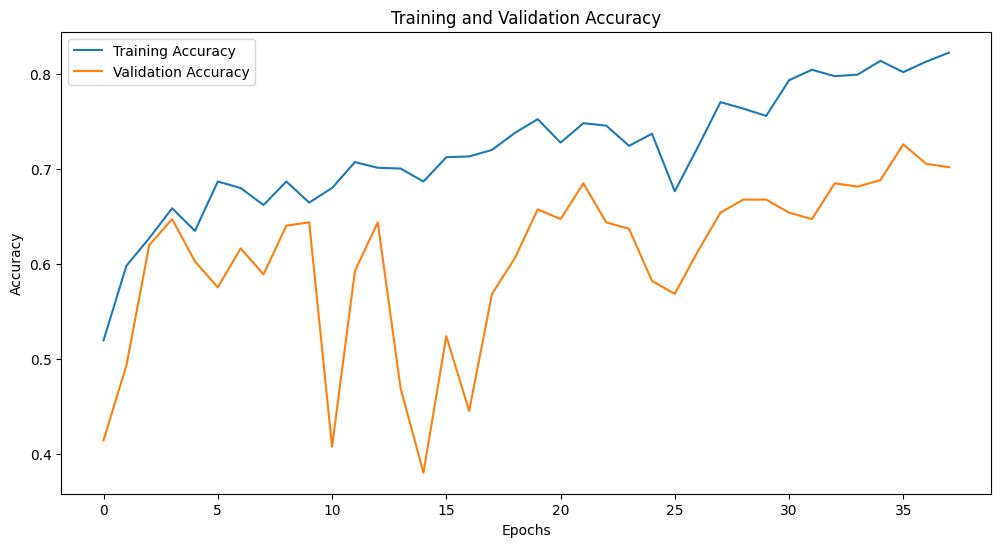

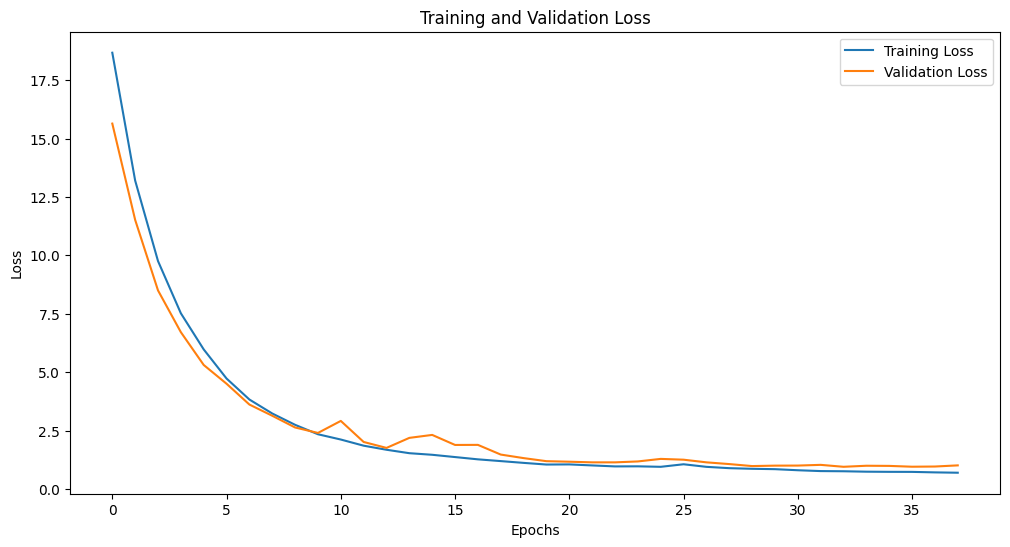

In [4]:
import tensorflow as tf
print(tf.__version__)

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset directory path
# dataset_path = '/content/drive/MyDrive/sinusities/sinusities_dataset'

# Directories
TRAIN_DIR = "/content/drive/MyDrive/sinusities/verified/train"
# VAL_DIR = "/content/drive/MyDrive/sinusities/verified/val" # not enough data

# Enhanced Dataset Preprocessing with More Augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2 # must use if not have different dataset for train and val
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    subset='training' # must use if not have different dataset for train and val
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    subset='validation' # must use if not have different dataset for train and val
)

# Load Pre-Trained InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Build Custom Layers on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)          # Dropout to reduce overfitting
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)          # Additional Dropout for regularization
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model with a Warm-Up Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Start with a high learning rate for warm-up
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Training
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
]

# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # Fewer epochs for warm-up
    callbacks=callbacks
)

# Fine-Tune the Model
# Gradually Unfreeze Layers for Fine-Tuning
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

# Recompile with a Lower Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Fine-Tuned Model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

# Save the Model
model.save('/content/drive/MyDrive/sinusities/inceptionv3.h5')

# Combine Histories for Visualization
history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


10/10 [==============================] - 86s 8s/step


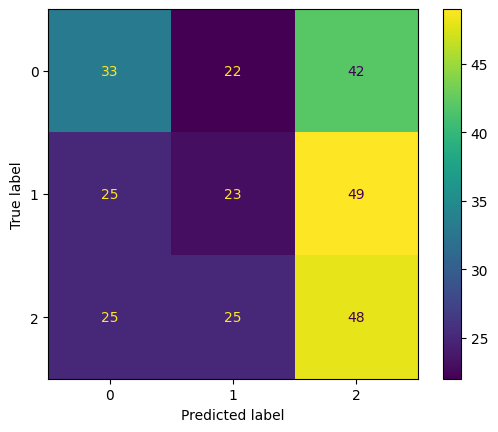

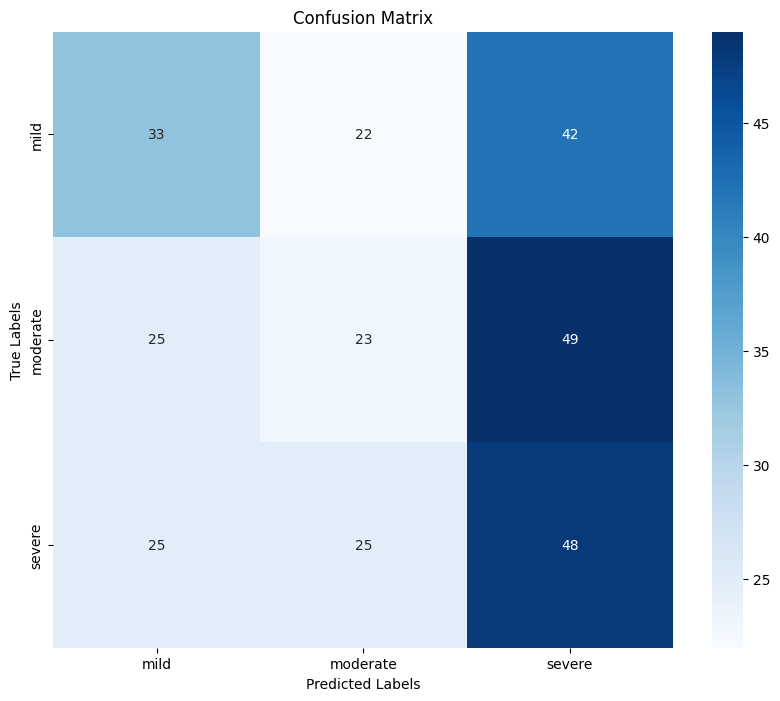

              precision    recall  f1-score   support

        mild       0.40      0.34      0.37        97
    moderate       0.33      0.24      0.28        97
      severe       0.35      0.49      0.41        98

    accuracy                           0.36       292
   macro avg       0.36      0.36      0.35       292
weighted avg       0.36      0.36      0.35       292



In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Predict on test data
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# 4. Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2 ])

cm_display.plot()
plt.show()

# 5. Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 6. Classification report (optional)
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

37/37 [==============================] - 336s 9s/step


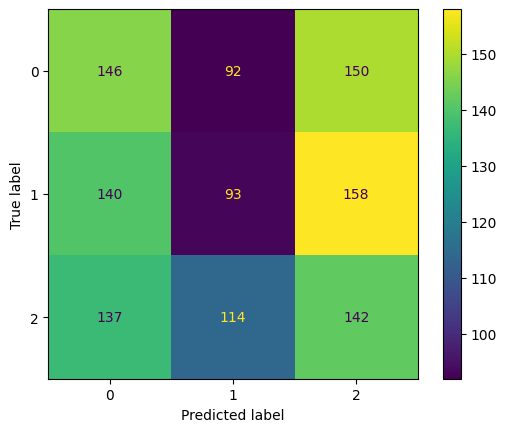

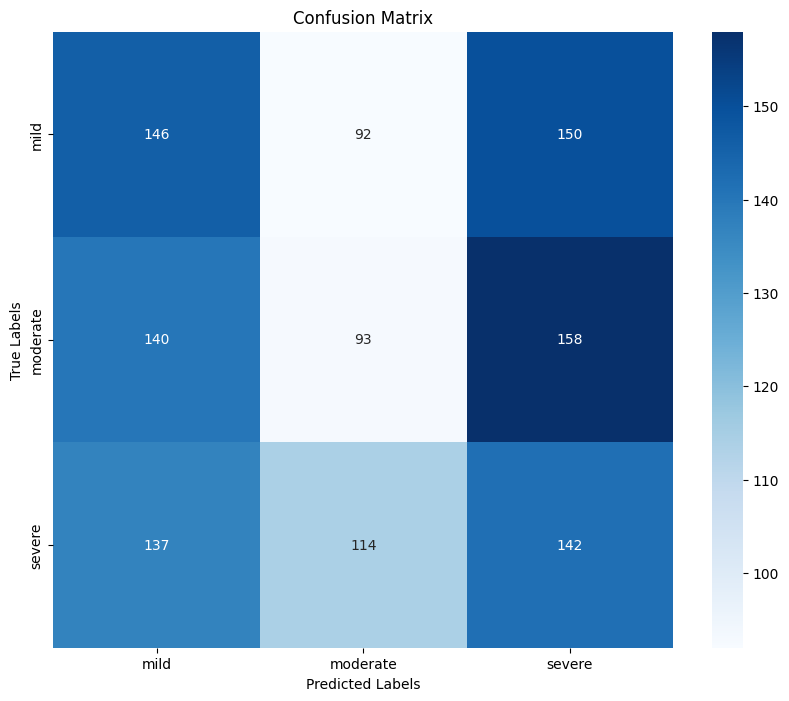

              precision    recall  f1-score   support

        mild       0.35      0.38      0.36       388
    moderate       0.31      0.24      0.27       391
      severe       0.32      0.36      0.34       393

    accuracy                           0.33      1172
   macro avg       0.32      0.33      0.32      1172
weighted avg       0.32      0.33      0.32      1172



In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Predict on test data
predictions = model.predict(train_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

# 4. Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2 ])

cm_display.plot()
plt.show()

# 5. Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 6. Classification report (optional)
print(classification_report(true_classes, predicted_classes, target_names=class_labels))